In [4]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb
from scipy.spatial.distance import cdist
from scipy.integrate import odeint
import warnings
import sys
warnings.simplefilter('error')


"""
This program simulated the shock 


    - Odeint integration
    - Verlet integration
    
Autor: Hernan Salinas 
Date_update : 2/21/2021

Reference: https://core.ac.uk/download/pdf/81947104.pdf
Sci Direct 14 (2011) 2743–2750
"""


'\nThis program simulated the shock \n\n\n    - Odeint integration\n    - Verlet integration\n    \nAutor: Hernan Salinas \nDate_update : 2/21/2021\n\nReference: https://core.ac.uk/download/pdf/81947104.pdf\nSci Direct 14 (2011) 2743–2750\n'

# Problems, the shock tube
Shock tube in 1 Dimension without viscous streess and heat.  The shock tube is a long straight tube filled with gas, which is separated by a membrane in two parts with different pressures and densities but are individually in thermodynamic equilibrium. 

When the membrane is taken away the following are produce:
- A schock wave-moves into region of lower density 
- A rarefaction wave(reduction in density)-moves into region of high density
- A contact discontinuity-forms in center and travels inton low density region behind the shock


Parameter of the regions in the tube:
### left region 
$x \leq 0$, $\rho =    1$, $v=0$, $e = 2.500$, $p=1$ $ \Delta x=0.001875 $

### right region 
$x > 0$, $\rho = 0.25$, $v=0$, $e = 1.795$, $p=0.1795$ $ \Delta x=0.0075 $

Parameter:
- $\rho$ : Density
- P : Pressure
- e : Internal energy
- v : velocity
- $\Delta x$ : particle spacing
- m : 0.001875.
- Np: 320 distributed in the hight density region 
- Np: 80 in the low density region 
- [-0.6------------------0.0-----------------------0.6]


We use the following equation of state:

- $p=(\gamma-1)\rho e$
- $c = \sqrt{(\gamma-1)e}$

with $\gamma = 1.4$, the time step to $0.005$ and run the simulation for 40 time steps


## Navier Stokes equation 

- Continuity equation
\begin{equation}
\frac{D \rho}{Dt} = \sum_{j=1}^N m_j (v_j-v_i)\cdot \nabla_i W_{ij}
\end{equation}

or 

\begin{equation}
\rho_i = \sum_{j=1}^N m_j W_{ij}
\end{equation}

- Momentum equation  
\begin{equation}
\frac{D v_i}{Dt} = \sum_{j=1}^N m_j \left( \frac{P_i}{\rho_i^2}+ \frac{P_j}{\rho_j^2}\right) \nabla_i W_{ij}
\end{equation}


- Internal Energy 
\begin{equation}
\frac{D e_i}{Dt} = \sum_{j=1}^N m_j \left( \frac{P_i}{\rho_i^2}+ \frac{P_j}{\rho_j^2} + \Pi_{ij} \right) (v_i-v_j) \cdot \nabla_i W_{ij}\nabla_i W_{ij}
\end{equation}

- Velocity
\begin{equation}
\frac{D x_i}{Dt} = v_i
\end{equation}





## Kernel and its derivative

### Cubic spline

\begin{equation}
 W(R,h)=\alpha_d \left\{ \begin{array}{ll}
         \frac{2}{3} - q^2 +\frac{1}{2}q^3 & \mbox{si $ 0 \leq q < 1 $};\\
         \frac{1}{6}(2 -q)^3 & \mbox{si $1 \leq q < 2$}.\\
 0 & \mbox{si $q \geq 2$ }          \end{array} \right. 
\end{equation}

\begin{equation}
 W'(R,h)=\alpha_d \left\{ \begin{array}{ll}
         (-2 + \frac{3}{2}q)\frac{d\bf{x}}{h^2} & \mbox{si $ 0 \leq q < 1 $};\\
         \frac{1}{2}(2 -q)^2\frac{d\bf{x}}{hr} & \mbox{si $1 \leq q < 2$}.\\
 0 & \mbox{si $q \geq 2$ }          \end{array} \right. 
\end{equation}


- $q= \frac{r_{ij}}{h}=\frac{|\vec{r}_i-\vec{r}_j|}{h}$
- In 1D $\alpha_d = 1/h $
- In 2D $\alpha_d = 15/(7\pi h^2) $
- In 3D $\alpha_d = 3/(2\pi h^3) $


In [18]:


def KernelPolynomial(R,h):
    """
    Input: Radii of particle and h 
    Output: Kernel W
    """ 
    
    
    W0 = 15./(7 * np.pi*h) #1.0# (np.pi * 4 * h** 3) ** (-1)
    W = 0
    q = R/h

    if 0 <= q <  1:
        
        W = (4 - 6* q  ** 2 + 3  * q **3)
    
    elif  1 <= q < 2:
        
        W =   (2 - q ) ** 3 #(1./4) * (2 - ( q )) ** 3
    
    elif q >= 2:
        
        W = 0
        
    else:
        print("Error kernel Polynomial!",R)
    
    return W


def kernelPolynomial_p(R, h):
    #REvisar si es utlizado
    W0 = 15/(7 * np.pi*3*h**2)# (np.pi * 4 * h** 3) ** (-1)
    #W = 0
    q = R/h
    
    if 0. <= q <  1:
        
        W = -12*q+9*q**2 #-(3./h) * q + (9./(4*h)) * q **2
    
    elif  1 <= q < 2:
        
        W = -3*(2-q)**2#-(3./(4*h)) * (2 - ( q )) ** 2
    
    elif q >= 2:
        
        W = 0
        
    else:
        print("Error kernel Polynomial!",R)
    
    return W
    
    
    


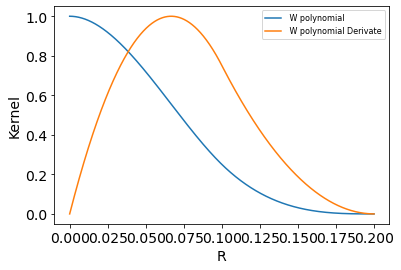

In [22]:
h = 0.1
step =  h /1000
R = np.arange(0, 2*h, step)

#KG = KernelGaussian(R, h) #kernel gaussiano
#KP = kernelPolinomial_(R, h) #kernel gaussiano
KP = np.array([KernelPolynomial(r,h) for r in R]) # kernel polinomial

KP_p = np.array([kernelPolynomial_p(r,h) for r in R]) #derivate of kernel polinomial 

plt.figure(figsize=(6,4))
plt.plot(R, KP/np.max(KP),  label = " W polynomial")
plt.plot(R, KP_p/np.min(KP_p),  label = " W polynomial Derivate")
plt.xlabel("R",  fontsize=14)
plt.ylabel("Kernel", fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 8)
plt.show()

In [17]:
#Parameter 
ρ1 = 1.0
ρ2 = 0.25
e1 = 2.5
e2 = 1.795
γ  = 1.4 
L  = 1.2 #unit
m0 = (ρ1+ρ2)* L / NP

mass = m0*np.ones(NP)
#Position of particles

x_left  = np.linspace(-0.6,0.0, 320)
x_right = np.linspace(0.0,0.6, 80)
x = np.concatenate([x_left,x_right])

In [ ]:
def compute_force_i(i, pos_r, vel, ρ, mass ):
    """
    --Input--
    i  :i-th particle
    pos: vector pos_r
    vel: vector velocity
    ρ   :density 
    P   : Preasure
    mass   : mass
    
    --Output--
    dvdt, ρ, P
    Force the i-th particle
    
    """
    g     = np.array([0, 0])
    R     = np.zeros((Nt,Nt))
       
    densidad = 0
    Fij = 0
    T2  = 0
    T1  = 0
    P     = eos(P0,  ρ, ρ0,γ) #initial Preasure
        
    for j in range(0, Nt):
        if(i != j):
            Πij = 0
            hij= (h[i]+h[j])*0.5
            cij=0.5*c[i]+c[j]
        
            
            Rij = pos_r[j] - pos_r[i] #vector
            if(abs(Rij)>2*hij):
                continue
            R[i,j] = np.linalg.norm(Rij)         #magnitude
            vij    = vel[j] - vel[i]        #vector
           
            #Preasure term
            T1  -= mass[j] *  (P[j] / ρ[j] ** 2 + P[i] / ρ[i] ** 2+Πij) * derivadaKernel * (Rij/R[i,j]) 
            T2  += 0.5 *mass[j] *  (P[j] / ρ[j] ** 2 + P[i] / ρ[i] ** 2+Πij)*vij*derivadaKernel * (Rij/R[i,j])
            #dρdt[j]  += mass[j]*(vel[i]-vel[j])*Kernel
            #densidad += mass[j] * np.dot(vel[i] - vel[j], Kernel * (Rij / R[i,j]))
            
    dvdt = T1
    dedt = T2
    return  dvdt,dedt 
